### Задание
Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

1. Возьмите датасет EMNIST из torchvision
1. Обучите на нём модели (с нуля по 10 эпох):
    * ResNet 18,
    * VGG 16,
    * Inception v3,
    * DenseNet 161.
1. Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.

In [1]:
from collections import defaultdict

In [2]:
dd_list = defaultdict(int)
dd_list['key1']=0
print(dd_list,dd_list['key1'],dd_list['key2'],dd_list.get('key2'))

defaultdict(<class 'int'>, {'key1': 0, 'key2': 0}) 0 0 0


In [3]:
dd_list = defaultdict(list)
dd_list['key1'].append(1)
print(dd_list,dd_list['key1'],dd_list['key2'])

defaultdict(<class 'list'>, {'key1': [1], 'key2': []}) [1] []


In [4]:
dd_list = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
dd_list['key1']['jey1']['hey1'].append(1)
print(dd_list,'\n',dd_list['key1']['jey1']['hey1'],'\n',dd_list['key2']['jey2']['hey2'],'\n',
      dd_list['key1']['jey1'],'\n',dd_list['key2']['jey2'],'\n',
      dd_list['key1'],'\n',dd_list['key2'],'\n')

defaultdict(<function <lambda> at 0x7ab582b26440>, {'key1': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7ab582b26560>, {'jey1': defaultdict(<class 'list'>, {'hey1': [1]})}), 'key2': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7ab582b265f0>, {'jey2': defaultdict(<class 'list'>, {'hey2': []})})}) 
 [1] 
 [] 
 defaultdict(<class 'list'>, {'hey1': [1]}) 
 defaultdict(<class 'list'>, {'hey2': []}) 
 defaultdict(<function <lambda>.<locals>.<lambda> at 0x7ab582b26560>, {'jey1': defaultdict(<class 'list'>, {'hey1': [1]})}) 
 defaultdict(<function <lambda>.<locals>.<lambda> at 0x7ab582b265f0>, {'jey2': defaultdict(<class 'list'>, {'hey2': []})}) 



In [6]:
import time
import pandas as pd
import torchvision as tv
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
#from torchsummary import summary
%matplotlib inline

In [7]:
BATCH_SIZE = 256

transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST(
    '.', split='mnist', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.EMNIST(
    '.', split='mnist', train=False, transform=transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


100%|██████████| 561753746/561753746 [00:05<00:00, 110742032.80it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [9]:
history = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
list_types_NN=['ResNet18','VGG16','Inception_v3','DenseNet161']

In [93]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 40))
    j=0
    for type_NN in list_types_NN:
        j+=1
        plt.subplot(4,2,j)
        plt.title(f'{type_NN}_loss', fontsize=15)
        plt.plot(history[type_NN]['loss']['train'], label=f'{type_NN}_train')
        plt.plot(history[type_NN]['loss']['val'], label=f'{type_NN}_val')
        plt.ylabel('loss', fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.legend()

        j+=1
        plt.subplot(4,2,j)
        plt.title(f'{type_NN}_accuracy', fontsize=15)
        plt.plot(history[type_NN]['acc']['train'], label=f'{type_NN}_train')
        plt.plot(history[type_NN]['acc']['val'], label=f'{type_NN}_val')
        plt.ylabel('accuracy', fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.legend()
        
    plt.show()

In [79]:
def plot_NNaccurcy_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    

    plt.subplot(1,1,1)
    plt.title('Accuracy', fontsize=15)
    
    for type_NN in list_types_NN:
        plt.plot(history[type_NN]['acc']['val'], label=type_NN)
        
    plt.ylabel('accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()#'ResNet18','VGG16','Inception_v3','DenseNet161'
    plt.show()

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [13]:
def evaluate_accuracy(data_iter, net, name_NN):
    loss = nn.CrossEntropyLoss(reduction='sum')
    acc_sum, n, test_loss = 0, 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        '''if name_NN==list_types_NN[2]:
          y_pred = net(X)
        else:
          y_pred = net(X)'''
        #print(net(X).flatten())
        #print(y)
        y_pred = net(X)
        l = loss(y_pred, y)
        test_loss += l.item()

        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]

    history[name_NN]['loss']['val'].append(test_loss/n)
    history[name_NN]['acc']['val'].append(acc_sum.item()/n)
    return acc_sum.item() / n, test_loss/n

In [14]:
def train(net, train_iter, test_iter, trainer, num_epochs, name_NN):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()

            '''if name_NN==list_types_NN[2]:
              y_hat,aux = net(X)
            else:
              y_hat = net(X)'''
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 50 == 0:
                print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")

        history[name_NN]['loss']['train'].append(train_l_sum / n)
        history[name_NN]['acc']['train'].append(train_acc_sum / n)

        test_acc, test_loss = evaluate_accuracy(test_iter, net.to(device),name_NN)

        print('-' * 20)
        print(f'epoch {epoch + 1}, testloss {test_loss:.4f}, trainloss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

#### ResNet 18

In [15]:
weights='IMAGENET1K_V1'
model = tv.models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s] 


In [ ]:
'''from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT #weights=ResNet50_Weights.DEFAULT
model = resnet18(weights=weights)'''

In [ ]:
#model = model.to(device)
model

In [ ]:
#summary(model.to(device), input_size=(3, 224, 224))

In [16]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [17]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [19]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [20]:
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [21]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [22]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [23]:
train(model, train_iter, test_iter, trainer, 10, list_types_NN[0])

Step 0. time since epoch: 6.652. Train acc: 0.121. Train Loss: 2.395
Step 50. time since epoch: 39.427. Train acc: 0.689. Train Loss: 1.314
Step 100. time since epoch: 71.994. Train acc: 0.792. Train Loss: 0.944
Step 150. time since epoch: 104.905. Train acc: 0.836. Train Loss: 0.762
Step 200. time since epoch: 137.669. Train acc: 0.861. Train Loss: 0.651
--------------------
epoch 1, testloss 0.2631, trainloss 0.5993, train acc 0.873, test acc 0.944, time 184.1 sec
Step 0. time since epoch: 0.649. Train acc: 0.914. Train Loss: 0.317
Step 50. time since epoch: 31.445. Train acc: 0.945. Train Loss: 0.251
Step 100. time since epoch: 62.388. Train acc: 0.946. Train Loss: 0.239
Step 150. time since epoch: 92.992. Train acc: 0.949. Train Loss: 0.228
Step 200. time since epoch: 123.585. Train acc: 0.950. Train Loss: 0.220
--------------------
epoch 2, testloss 0.1803, trainloss 0.2148, train acc 0.951, test acc 0.958, time 168.8 sec
Step 0. time since epoch: 0.602. Train acc: 0.938. Train Lo

In [24]:
history

defaultdict(<function __main__.<lambda>()>,
            {'ResNet18': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'loss': defaultdict(list,
                                      {'train': [0.5992975049654643,
                                        0.21481255989074707,
                                        0.1620771795272827,
                                        0.13703626092274984,
                                        0.1217817553838094,
                                        0.11126076785723368,
                                        0.10343735098838806,
                                        0.09731403398513794,
                                        0.0923405577023824,
                                        0.08818813219070434],
                                       'val': [0.2630953554868698,
                                        0.18030823657512665,
                                        0.14837975037693976,
            

In [ ]:
#plot_learning_curves(history)

#### VGG16

In [25]:
model = tv.models.vgg16(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 118MB/s]  


In [ ]:
model

In [ ]:
#summary(model.to(device), input_size=(3, 224, 224))

In [27]:
for param in model.parameters():
    param.requires_grad = False

In [28]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [29]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=10)
model.classifier[6]

Linear(in_features=4096, out_features=10, bias=True)

In [30]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [31]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [32]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [33]:
train(model, train_iter, test_iter, trainer, 10, list_types_NN[1])

Step 0. time since epoch: 1.844. Train acc: 0.094. Train Loss: 2.354
Step 50. time since epoch: 82.840. Train acc: 0.691. Train Loss: 1.099
Step 100. time since epoch: 164.678. Train acc: 0.765. Train Loss: 0.836
Step 150. time since epoch: 247.423. Train acc: 0.798. Train Loss: 0.714
Step 200. time since epoch: 330.978. Train acc: 0.817. Train Loss: 0.640
--------------------
epoch 1, testloss 0.2941, trainloss 0.6066, train acc 0.826, test acc 0.930, time 486.7 sec
Step 0. time since epoch: 1.670. Train acc: 0.953. Train Loss: 0.271
Step 50. time since epoch: 85.541. Train acc: 0.939. Train Loss: 0.268
Step 100. time since epoch: 169.198. Train acc: 0.942. Train Loss: 0.254
Step 150. time since epoch: 252.574. Train acc: 0.943. Train Loss: 0.243
Step 200. time since epoch: 335.779. Train acc: 0.945. Train Loss: 0.233
--------------------
epoch 2, testloss 0.1878, trainloss 0.2268, train acc 0.946, test acc 0.953, time 490.8 sec
Step 0. time since epoch: 1.666. Train acc: 0.961. Train

#### Inception v3

In [34]:
model = tv.models.inception_v3(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 221MB/s]  


In [35]:
model.aux_logits=False

In [36]:
model.aux_logits

False

In [37]:
BATCH_SIZE = 256

transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST(
    '.', split='mnist', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.EMNIST(
    '.', split='mnist', train=False, transform=transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
#summary(model.to(device), input_size=( 3,299,299))

In [38]:
for param in model.parameters():
    param.requires_grad = False
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [39]:
model.fc=nn.Linear(in_features=2048, out_features=10)
model.fc

Linear(in_features=2048, out_features=10, bias=True)

In [40]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [41]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

This network is unique because it has two output layers when training. The primary output is a linear layer at the end of the network. The second output is known as an auxiliary output and is contained in the AuxLogits part of the network.

In [42]:
train(model, train_iter, test_iter, trainer, 10, list_types_NN[2])

Step 0. time since epoch: 1.768. Train acc: 0.133. Train Loss: 2.318
Step 50. time since epoch: 90.801. Train acc: 0.598. Train Loss: 1.508
Step 100. time since epoch: 179.201. Train acc: 0.687. Train Loss: 1.195
Step 150. time since epoch: 267.572. Train acc: 0.730. Train Loss: 1.031
Step 200. time since epoch: 355.831. Train acc: 0.753. Train Loss: 0.931
--------------------
epoch 1, testloss 0.4854, trainloss 0.8816, train acc 0.764, test acc 0.879, time 492.3 sec
Step 0. time since epoch: 1.658. Train acc: 0.871. Train Loss: 0.500
Step 50. time since epoch: 85.186. Train acc: 0.883. Train Loss: 0.458
Step 100. time since epoch: 168.056. Train acc: 0.889. Train Loss: 0.440
Step 150. time since epoch: 249.988. Train acc: 0.892. Train Loss: 0.423
Step 200. time since epoch: 332.167. Train acc: 0.894. Train Loss: 0.411
--------------------
epoch 2, testloss 0.3480, trainloss 0.4026, train acc 0.895, test acc 0.907, time 464.5 sec
Step 0. time since epoch: 1.652. Train acc: 0.891. Train

In [56]:
history

defaultdict(<function __main__.<lambda>()>,
            {'ResNet18': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'loss': defaultdict(list,
                                      {'train': [0.5992975049654643,
                                        0.21481255989074707,
                                        0.1620771795272827,
                                        0.13703626092274984,
                                        0.1217817553838094,
                                        0.11126076785723368,
                                        0.10343735098838806,
                                        0.09731403398513794,
                                        0.0923405577023824,
                                        0.08818813219070434],
                                       'val': [0.2630953554868698,
                                        0.18030823657512665,
                                        0.14837975037693976,
            

#### DenseNet161

In [52]:
model = tv.models.densenet161(weights='IMAGENET1K_V1')

In [54]:
BATCH_SIZE = 256
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST(
    '.', split='mnist', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.EMNIST(
    '.', split='mnist', train=False, transform=transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [55]:
#model = model.to(device)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
#summary(model.to(device), input_size=(3, 224, 224))

In [57]:
for param in model.parameters():
    param.requires_grad = False
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [58]:
model.classifier=nn.Linear(in_features=2208, out_features=10)
model.classifier

Linear(in_features=2208, out_features=10, bias=True)

In [59]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [60]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [61]:
device

'cuda'

In [62]:
train(model, train_iter, test_iter, trainer, 10, list_types_NN[3])

Step 0. time since epoch: 2.215. Train acc: 0.105. Train Loss: 2.303
Step 50. time since epoch: 113.455. Train acc: 0.729. Train Loss: 1.193
Step 100. time since epoch: 227.507. Train acc: 0.809. Train Loss: 0.860
Step 150. time since epoch: 342.353. Train acc: 0.847. Train Loss: 0.699
Step 200. time since epoch: 457.979. Train acc: 0.867. Train Loss: 0.603
--------------------
epoch 1, testloss 0.2595, trainloss 0.5573, train acc 0.877, test acc 0.941, time 671.1 sec
Step 0. time since epoch: 2.133. Train acc: 0.945. Train Loss: 0.287
Step 50. time since epoch: 109.258. Train acc: 0.946. Train Loss: 0.241
Step 100. time since epoch: 215.367. Train acc: 0.947. Train Loss: 0.230
Step 150. time since epoch: 321.123. Train acc: 0.948. Train Loss: 0.221
Step 200. time since epoch: 426.972. Train acc: 0.950. Train Loss: 0.213
--------------------
epoch 2, testloss 0.1797, trainloss 0.2091, train acc 0.950, test acc 0.956, time 632.7 sec
Step 0. time since epoch: 2.182. Train acc: 0.945. Tra

In [69]:
history

defaultdict(<function __main__.<lambda>()>,
            {'ResNet18': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'loss': defaultdict(list,
                                      {'train': [0.5992975049654643,
                                        0.21481255989074707,
                                        0.1620771795272827,
                                        0.13703626092274984,
                                        0.1217817553838094,
                                        0.11126076785723368,
                                        0.10343735098838806,
                                        0.09731403398513794,
                                        0.0923405577023824,
                                        0.08818813219070434],
                                       'val': [0.2630953554868698,
                                        0.18030823657512665,
                                        0.14837975037693976,
            

In [70]:
from prettytable import PrettyTable
mytable = PrettyTable()
# имена полей таблицы
clmn=["NeuralNetworkName"]
[clmn.append(f'epoch{x}') for x in range(1,11,1)]
mytable.field_names = clmn
# добавление данных по одной строке за раз
empt=[f'{list_types_NN[0]}_TEST_Accuracy']
[empt.append(x) for x in history[list_types_NN[0]]['acc']['val']]
mytable.add_row(empt)

empt=[f'{list_types_NN[1]}_TEST_Accuracy']
[empt.append(x) for x in history[list_types_NN[1]]['acc']['val']]
mytable.add_row(empt)

empt=[f'{list_types_NN[2]}_TEST_Accuracy']
[empt.append(x) for x in history[list_types_NN[2]]['acc']['val']]
mytable.add_row(empt)

empt=[f'{list_types_NN[3]}_TEST_Accuracy']
[empt.append(x) for x in history[list_types_NN[3]]['acc']['val'][1:]]
mytable.add_row(empt)

print(mytable)

+----------------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+
|     NeuralNetworkName      | epoch1 | epoch2 | epoch3 | epoch4 | epoch5 | epoch6 | epoch7 | epoch8 | epoch9 | epoch10 |
+----------------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+
|   ResNet18_TEST_Accuracy   | 0.9436 | 0.9579 | 0.9636 | 0.966  | 0.9678 | 0.9692 | 0.9697 | 0.9709 | 0.9721 |  0.9727 |
|    VGG16_TEST_Accuracy     | 0.9297 | 0.9534 | 0.9633 | 0.9685 | 0.9721 | 0.9736 | 0.9754 | 0.9762 | 0.9773 |  0.9783 |
| Inception_v3_TEST_Accuracy | 0.8786 | 0.9069 | 0.9203 | 0.928  | 0.9326 | 0.9365 | 0.9392 | 0.942  | 0.9424 |  0.9432 |
| DenseNet161_TEST_Accuracy  | 0.9409 | 0.9556 | 0.9615 | 0.9638 | 0.9661 | 0.9669 | 0.9677 | 0.9685 | 0.9687 |  0.9695 |
+----------------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+


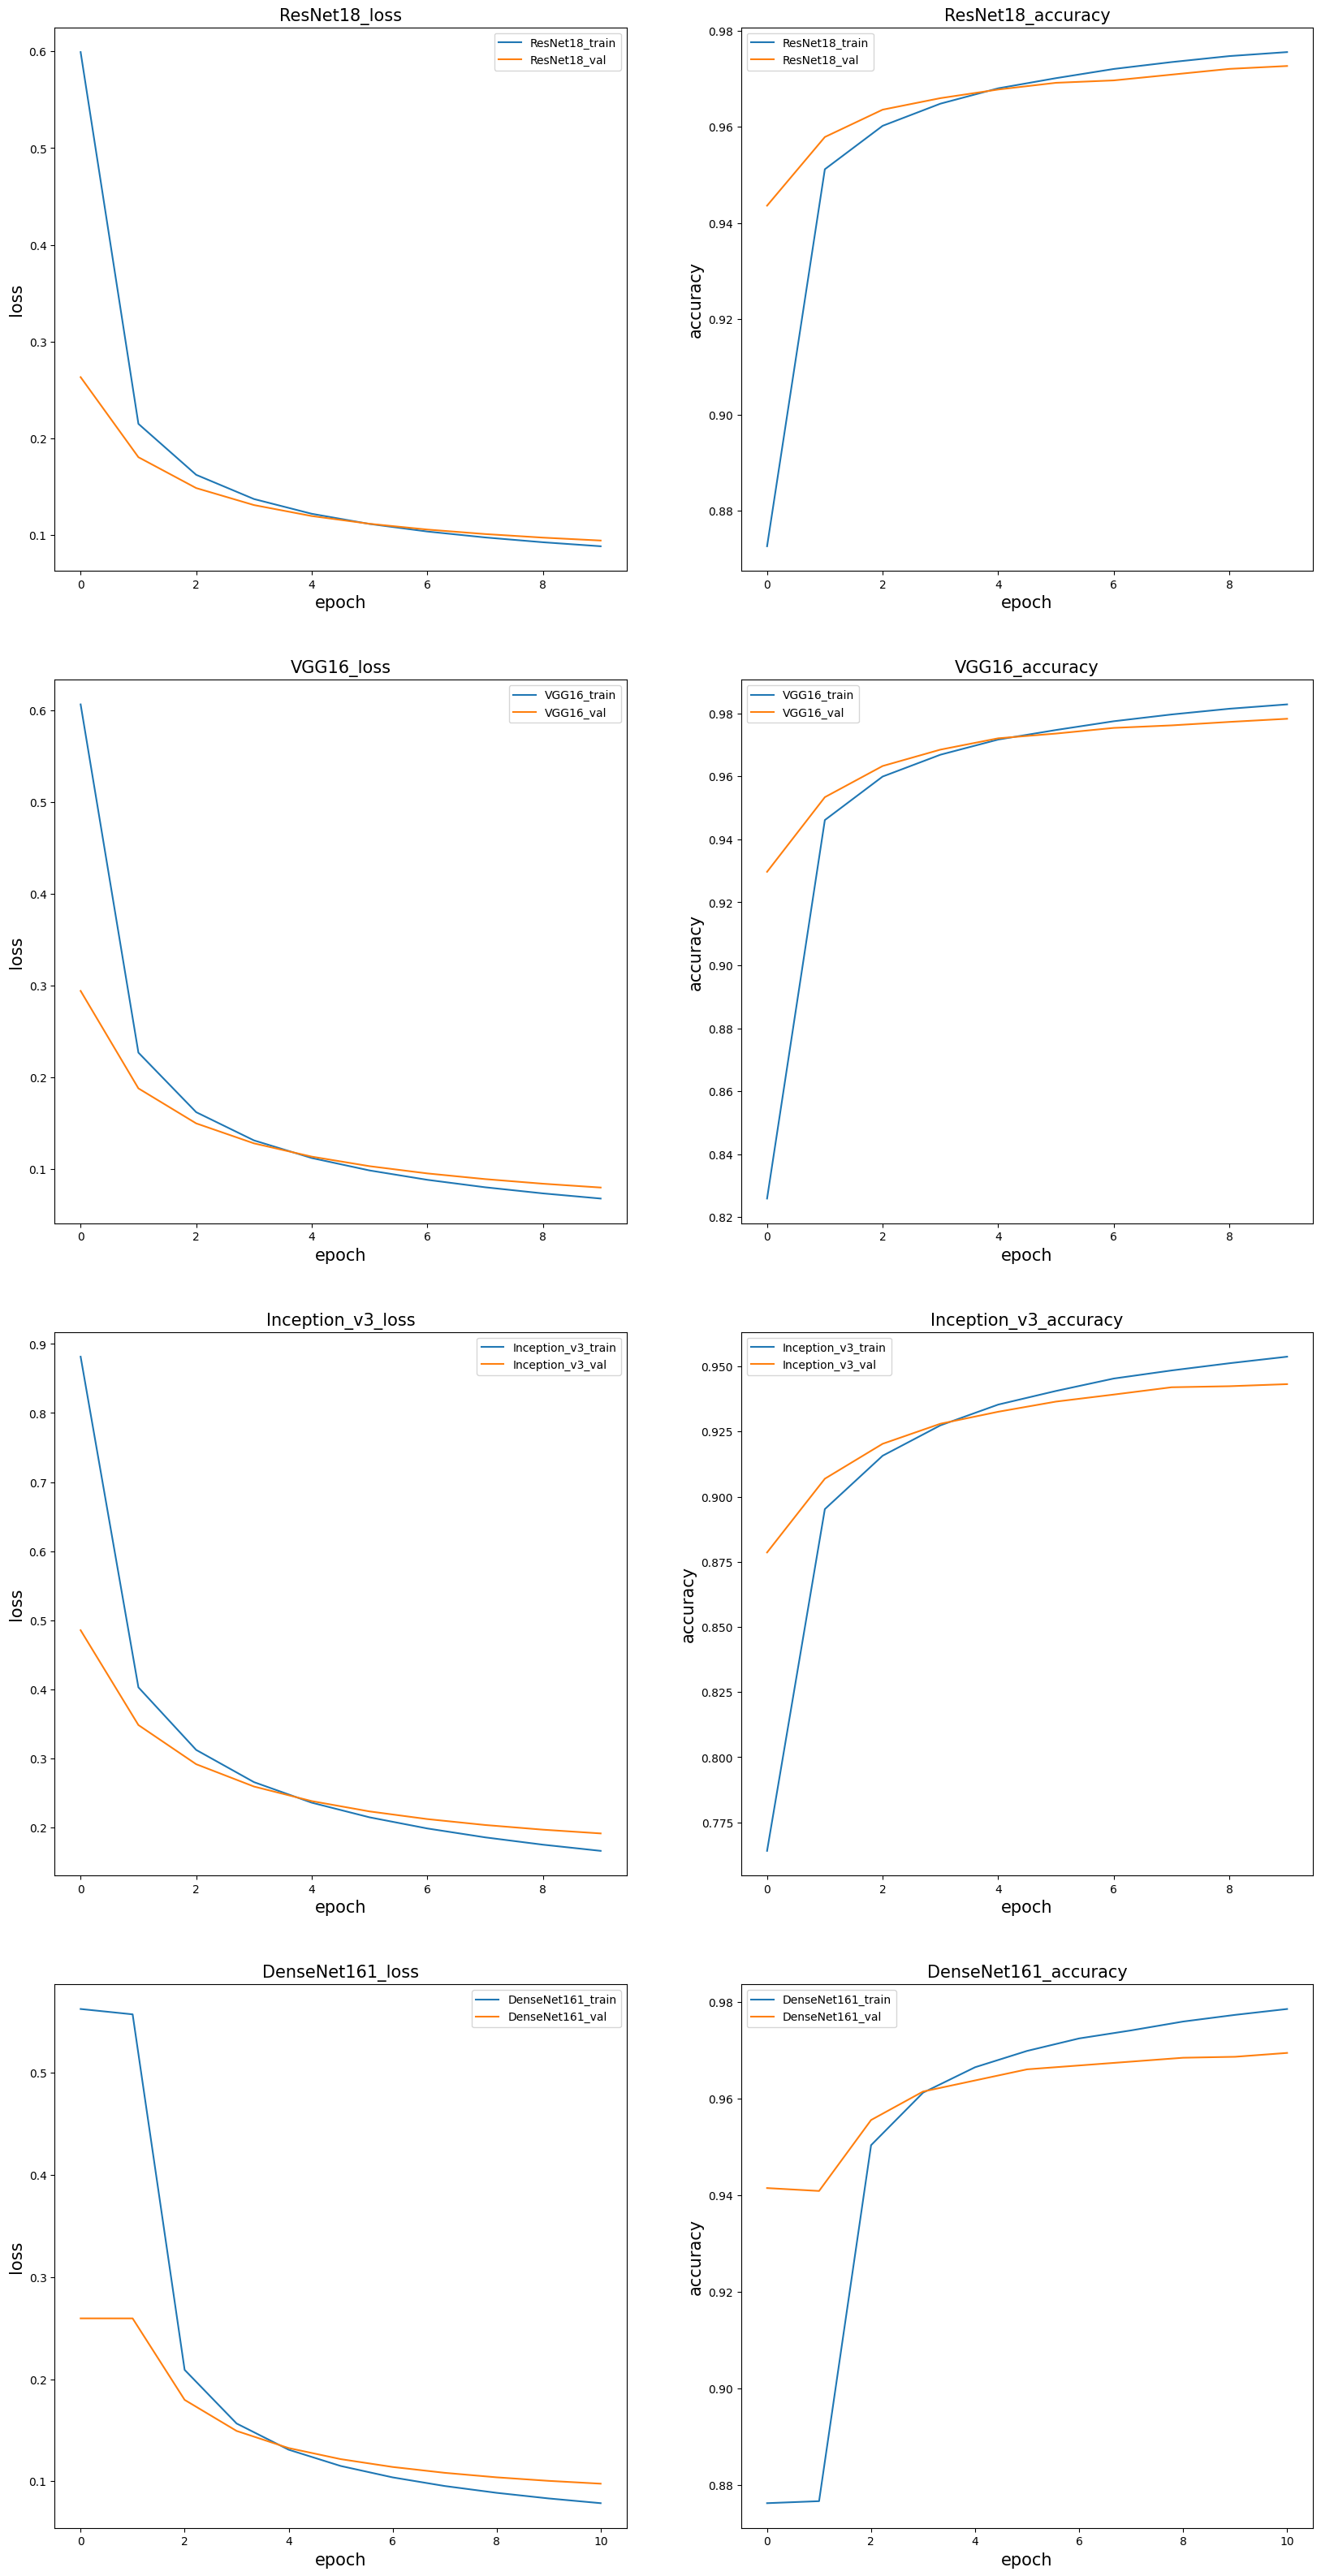

In [94]:
plot_learning_curves(history)

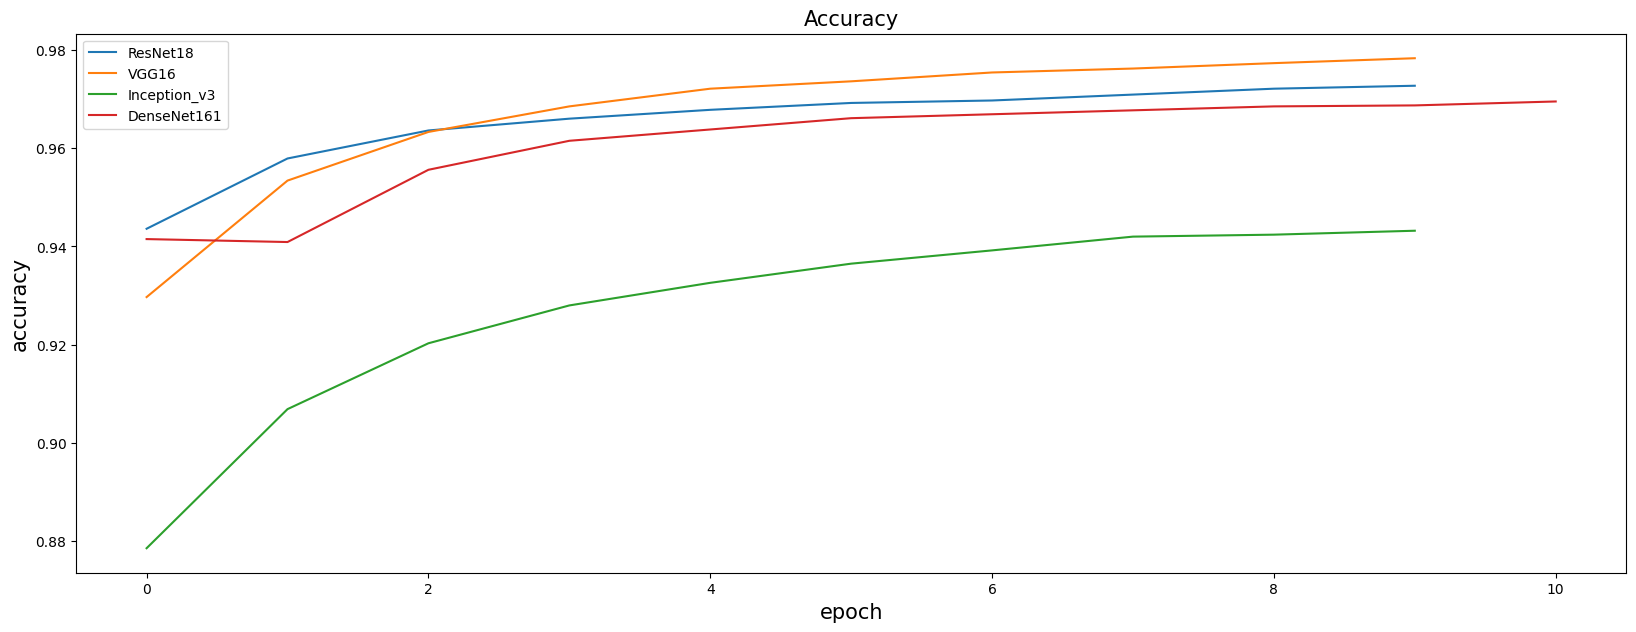

In [80]:
plot_NNaccurcy_curves(history)